In [1]:
### Load the required liberaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from dotenv import load_dotenv
import os

load_dotenv()  # Loads variables from .env
api_key = os.getenv("COMET_API_KEY")

In [3]:
import comet_ml
comet_ml.login(api_key)

exp = comet_ml.start(project_name="Fraud_Detection")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dushyant2/fraud-detection/502f7bf773a844368f315303c391b2f6



In [4]:
data = pd.read_csv(r"D:\Data_analytics_new\Sub5_Machine_Learning\Credit-Card-Fraud-Detection-Model\data\cleaned_data\train_raw2.csv")

In [5]:
data.head(2)

,Unnamed: 0,trans_num,trans_date,time_bucket,cc_num,amount_bkt,category,gender,state,latitudinal_distance,longitudinal_distance,population_bkt,age,is_fraud,age_bkt
0,0,0b242abb623afc578575680df30655b9,2019-01-01,12AM-6AM,CN - 2703186189652095,less than 5 dollar,misc_net,F,NC,0.068,0.870,Medium_pop,31,0,b/w 25 to 40
1,1,1f76529f8574734946361c461b024d99,2019-01-01,12AM-6AM,CN - 630423337322,b/w 80 to 150 dollar,grocery_pos,F,WA,0.271,0.024,Low_pop,41,0,b/w 40 to 60


In [6]:
data["is_fraud"].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [7]:
data["gender_encod"] = data["gender"].apply(lambda x: 1 if x=="M" else 0)

In [8]:
data.head(2)

,Unnamed: 0,trans_num,trans_date,time_bucket,cc_num,amount_bkt,category,gender,state,latitudinal_distance,longitudinal_distance,population_bkt,age,is_fraud,age_bkt,gender_encod
0,0,0b242abb623afc578575680df30655b9,2019-01-01,12AM-6AM,CN - 2703186189652095,less than 5 dollar,misc_net,F,NC,0.068,0.870,Medium_pop,31,0,b/w 25 to 40,0
1,1,1f76529f8574734946361c461b024d99,2019-01-01,12AM-6AM,CN - 630423337322,b/w 80 to 150 dollar,grocery_pos,F,WA,0.271,0.024,Low_pop,41,0,b/w 40 to 60,0


In [9]:
df = data.copy()

In [10]:
df.set_index("trans_num", inplace=True)

#### One Hot Encoding for categorical data

In [16]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'df' is your original DataFrame
# 1. Define columns to encode and drop
cat_cols = ['time_bucket', 'category', 'amount_bkt', 'population_bkt', 'age_bkt']
drop_cols = cat_cols + ["trans_date", "cc_num", "gender", "state", "age", 'Unnamed: 0']

# 2. Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # sparse_output is the new parameter name

# 3. Fit and transform categorical columns
X_encoded = encoder.fit_transform(df[cat_cols])

# 4. Get feature names
encoded_feat_names = encoder.get_feature_names_out(cat_cols)

# 5. Create DataFrame with encoded features
encoded_df = pd.DataFrame(X_encoded, columns=encoded_feat_names, index=df.index)

# 6. Drop original columns
data_processed = df.drop(columns=drop_cols)

# 7. Merge encoded features with remaining data
final_df = pd.concat([data_processed, encoded_df], axis=1)

# Verification
print(f"Original shape: {df.shape}")
print(f"Final shape: {final_df.shape}")
print("\nNew columns:", list(encoded_df.columns))

Original shape: (1296675, 15)
Final shape: (1296675, 31)

New columns: ['time_bucket_12PM-6PM', 'time_bucket_6AM-12PM', 'time_bucket_6PM-12AM', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'amount_bkt_b/w 40 to 60 dollar', 'amount_bkt_b/w 5 to 10 dollar', 'amount_bkt_b/w 60 to 80 dollar', 'amount_bkt_b/w 80 to 150 dollar', 'amount_bkt_less than 5 dollar', 'amount_bkt_more than 150 dollar', 'population_bkt_Low_pop', 'population_bkt_Medium_pop', 'age_bkt_b/w 40 to 60', 'age_bkt_less than 25', 'age_bkt_more than 60']


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming final_df is your preprocessed DataFrame with all features
# Select only the numeric columns (excluding target variable if it exists)
numeric_cols = final_df.select_dtypes(include=['int64', 'float64']).columns
X_vif = final_df[numeric_cols]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]

# Sort by VIF in descending order
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display results
print("Variance Inflation Factor (VIF) Analysis:")
print(vif_data)

Variance Inflation Factor (VIF) Analysis:
                            feature       VIF
6              time_bucket_6PM-12AM  3.933486
4              time_bucket_12PM-6PM  3.906287
0              latitudinal_distance  3.726707
1             longitudinal_distance  3.718795
8            category_gas_transport  2.319766
27        population_bkt_Medium_pop  2.252264
10             category_grocery_pos  2.174909
28             age_bkt_b/w 40 to 60  2.094188
23  amount_bkt_b/w 80 to 150 dollar  2.090427
12                    category_home  2.052139
26           population_bkt_Low_pop  2.017900
13               category_kids_pets  1.979495
21    amount_bkt_b/w 5 to 10 dollar  1.964657
18            category_shopping_pos  1.945359
24    amount_bkt_less than 5 dollar  1.899429
5              time_bucket_6AM-12PM  1.879616
22   amount_bkt_b/w 60 to 80 dollar  1.854102
20   amount_bkt_b/w 40 to 60 dollar  1.837694
3                      gender_encod  1.820040
16           category_personal_care  1

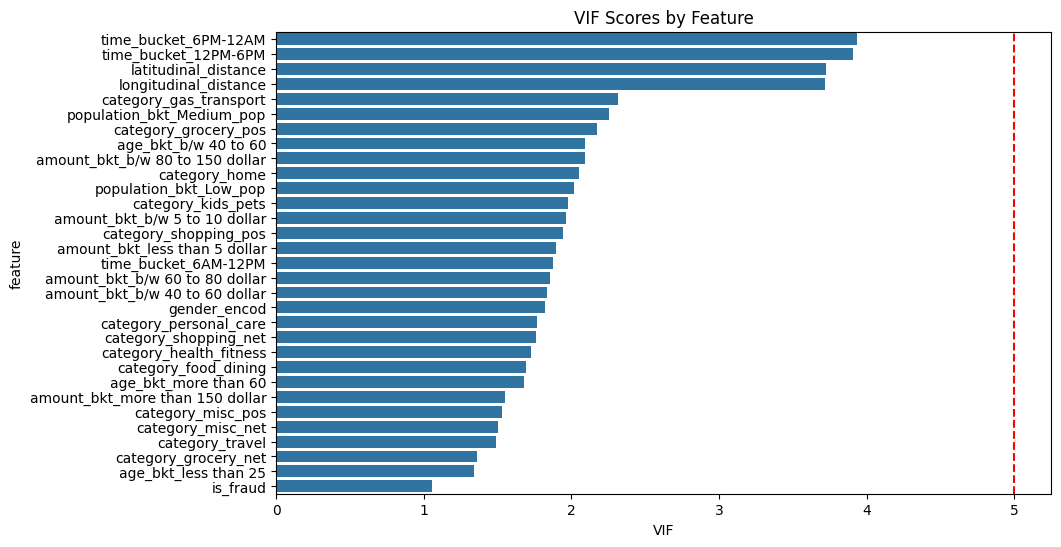

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x='VIF', y='feature', data=vif_data)
plt.axvline(x=5, color='red', linestyle='--')
plt.title("VIF Scores by Feature")
plt.show()

### SMOTE For Balancing the Dataset

In [19]:
X = final_df.drop(columns="is_fraud")
y = final_df.is_fraud

In [20]:
# 1. Split data (before any resampling!)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [21]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(972506, 30)
(324169, 30)
(972506,)
(324169,)


In [22]:
# 2. Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(1933754, 30)
(1933754,)


In [24]:
#### Modelling

from sklearn.linear_model import LogisticRegression

In [25]:
logit_model = LogisticRegression(solver="liblinear")
logit_model.fit(X_train_resampled,y_train_resampled)

LogisticRegression(solver='liblinear')

In [27]:
feature = pd.DataFrame()
feature['columns'] = X_train_resampled.columns
feature['importance'] = logit_model.coef_[0]
feature.sort_values(by="importance", ascending=False, inplace=True)
feature

,columns,importance
7,category_gas_transport,4.869432
8,category_grocery_net,3.876628
24,amount_bkt_more than 150 dollar,3.529498
14,category_misc_pos,2.443649
6,category_food_dining,2.268101
9,category_grocery_pos,2.130564
15,category_personal_care,2.053784
18,category_travel,1.989643
13,category_misc_net,1.715027
12,category_kids_pets,1.701139


In [28]:
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            classification_report, mean_absolute_error,
                            mean_squared_error, median_absolute_error,
                            roc_auc_score, precision_recall_curve, average_precision_score)


# Add model type note
exp.add_tag("Logistic Regression")
exp.log_parameter("model_type", "Logistic Regression with SMOTE")

# 1. Training and Test Scores
train_accuracy = logit_model.score(X_train_resampled, y_train_resampled)
test_accuracy = logit_model.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

# Log accuracy metrics
exp.log_metric("train_accuracy", train_accuracy)
exp.log_metric("test_accuracy", test_accuracy)

# 2. Predictions and Probabilities
Y_pred = logit_model.predict(X_val)
Y_probs = logit_model.predict_proba(X_val)[:, 1]

# 3. Error Metrics
mae = mean_absolute_error(y_val, Y_pred)
mse = mean_squared_error(y_val, Y_pred)
medae = median_absolute_error(y_val, Y_pred)

print("\nError Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")

exp.log_metrics({
    "mean_absolute_error": mae,
    "mean_squared_error": mse,
    "median_absolute_error": medae
})

# 4. Classification Metrics
accuracy = accuracy_score(y_val, Y_pred)
weighted_f1 = f1_score(y_val, Y_pred, average='weighted')

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1 Score: {weighted_f1:.2%}")

exp.log_metrics({
    "accuracy": accuracy,
    "weighted_f1": weighted_f1
})

# 5. Additional Important Metrics
print("\nDetailed Classification Report:")
clf_report = classification_report(y_val, Y_pred, target_names=['Non-Fraud', 'Fraud'], output_dict=True)
print(pd.DataFrame(clf_report).transpose())

# Log classification report
for label, metrics in clf_report.items():
    if label in ['Non-Fraud', 'Fraud']:
        exp.log_metrics({
            f"{label}_precision": metrics['precision'],
            f"{label}_recall": metrics['recall'],
            f"{label}_f1": metrics['f1-score'],
            f"{label}_support": metrics['support']
        })
    elif label == 'macro avg':
        exp.log_metrics({
            "macro_avg_precision": metrics['precision'],
            "macro_avg_recall": metrics['recall'],
            "macro_avg_f1": metrics['f1-score']
        })
    elif label == 'weighted avg':
        exp.log_metrics({
            "weighted_avg_precision": metrics['precision'],
            "weighted_avg_recall": metrics['recall'],
            "weighted_avg_f1": metrics['f1-score']
        })

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, Y_pred)
print(cm)

# Log and plot confusion matrix
exp.log_confusion_matrix(
    matrix=cm,
    labels=['Non-Fraud', 'Fraud'],
    title="Confusion Matrix"
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
exp.log_figure(figure_name="Confusion Matrix", figure=plt)
plt.close()

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, Y_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
exp.log_metric("roc_auc", roc_auc)

# PR Curve
precision, recall, _ = precision_recall_curve(y_val, Y_probs)
avg_precision = average_precision_score(y_val, Y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
exp.log_figure(figure_name="PR Curve", figure=plt)
plt.close()

# End the experiment
exp.end()

print("\nAll metrics have been logged to Comet ML")
print("Note: These results are from the Logistic Regression model with SMOTE resampling")

Training Accuracy: 89.30%
Test Accuracy: 86.72%

Error Metrics:
Mean Absolute Error: 0.1328
Mean Squared Error: 0.1328
Median Absolute Error: 0.0000

Classification Metrics:
Accuracy: 86.72%
Weighted F1 Score: 92.35%

Detailed Classification Report:
              precision    recall  f1-score        support
Non-Fraud      0.999374  0.866978  0.928480  322292.000000
Fraud          0.038184  0.906766  0.073282    1877.000000
accuracy       0.867208  0.867208  0.867208       0.867208
macro avg      0.518779  0.886872  0.500881  324169.000000
weighted avg   0.993809  0.867208  0.923528  324169.000000

Confusion Matrix:
[[279420  42872]
 [   175   1702]]

ROC-AUC Score: 0.9485


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : tired_cabana_3782
COMET INFO:     url                   : https://www.comet.com/dushyant2/fraud-detection/502f7bf773a844368f315303c391b2f6
COMET INFO:   Metrics:
COMET INFO:     Fraud_f1               : 0.07328152246453251
COMET INFO:     Fraud_precision        : 0.038183694530443756
COMET INFO:     Fraud_recall           : 0.906766116142781
COMET INFO:     Fraud_support          : 1877.0
COMET INFO:     Non-Fraud_f1           : 0.9284799306182058
COMET INFO:     Non-Fraud_precision    : 0.9993740946726515
COMET INFO:     Non-Fraud_recall       : 0.8669777717101262
COMET INFO:     Non-Fraud_support      : 322292.0
COMET INFO:     accuracy            


All metrics have been logged to Comet ML
Note: These results are from the Logistic Regression model with SMOTE resampling


In [29]:
### Random Forest Model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [ ]:

train_accuracy = rf.score(X_train_resampled, y_train_resampled)
test_accuracy = rf.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")





Training Accuracy: 100.00%
Test Accuracy: 97.79%


In [33]:
# 2. Predictions and Probabilities
#Y_pred = rf.predict(X_val)
Y_probs = rf.predict_proba(X_val)
Y_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(324169, 2))

In [35]:
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            classification_report, mean_absolute_error,
                            mean_squared_error, median_absolute_error,
                            roc_auc_score, precision_recall_curve, average_precision_score)

exp = comet_ml.start(project_name="Fraud_Detection")
# Add model type note
exp.add_tag("Random Forest Without Hypertune")
exp.log_parameter("model_type", "Random Forest with SMOTE")

# 1. Training and Test Scores
train_accuracy = rf.score(X_train_resampled, y_train_resampled)
test_accuracy = rf.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

# Log accuracy metrics
exp.log_metric("train_accuracy", train_accuracy)
exp.log_metric("test_accuracy", test_accuracy)

# 2. Predictions and Probabilities
Y_pred = rf.predict(X_val)
Y_probs = rf.predict_proba(X_val)[:, 1]

# 3. Error Metrics
mae = mean_absolute_error(y_val, Y_pred)
mse = mean_squared_error(y_val, Y_pred)
medae = median_absolute_error(y_val, Y_pred)

print("\nError Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Median Absolute Error: {medae:.4f}")

exp.log_metrics({
    "mean_absolute_error": mae,
    "mean_squared_error": mse,
    "median_absolute_error": medae
})

# 4. Classification Metrics
accuracy = accuracy_score(y_val, Y_pred)
weighted_f1 = f1_score(y_val, Y_pred, average='weighted')

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1 Score: {weighted_f1:.2%}")

exp.log_metrics({
    "accuracy": accuracy,
    "weighted_f1": weighted_f1
})

# 5. Additional Important Metrics
print("\nDetailed Classification Report:")
clf_report = classification_report(y_val, Y_pred, target_names=['Non-Fraud', 'Fraud'], output_dict=True)
print(pd.DataFrame(clf_report).transpose())

# Log classification report
for label, metrics in clf_report.items():
    if label in ['Non-Fraud', 'Fraud']:
        exp.log_metrics({
            f"{label}_precision": metrics['precision'],
            f"{label}_recall": metrics['recall'],
            f"{label}_f1": metrics['f1-score'],
            f"{label}_support": metrics['support']
        })
    elif label == 'macro avg':
        exp.log_metrics({
            "macro_avg_precision": metrics['precision'],
            "macro_avg_recall": metrics['recall'],
            "macro_avg_f1": metrics['f1-score']
        })
    elif label == 'weighted avg':
        exp.log_metrics({
            "weighted_avg_precision": metrics['precision'],
            "weighted_avg_recall": metrics['recall'],
            "weighted_avg_f1": metrics['f1-score']
        })

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, Y_pred)
print(cm)

# Log and plot confusion matrix
exp.log_confusion_matrix(
    matrix=cm,
    labels=['Non-Fraud', 'Fraud'],
    title="Confusion Matrix"
)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
exp.log_figure(figure_name="Confusion Matrix", figure=plt)
plt.close()

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, Y_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")
exp.log_metric("roc_auc", roc_auc)

# PR Curve
precision, recall, _ = precision_recall_curve(y_val, Y_probs)
avg_precision = average_precision_score(y_val, Y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
exp.log_figure(figure_name="PR Curve", figure=plt)
plt.close()

# End the experiment
exp.end()

print("\nAll metrics have been logged to Comet ML")
print("Note: These results are from the Logistic Regression model with SMOTE resampling")

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Training Accuracy: 100.00%
Test Accuracy: 97.79%

Error Metrics:
Mean Absolute Error: 0.0221
Mean Squared Error: 0.0221
Median Absolute Error: 0.0000

Classification Metrics:
Accuracy: 97.79%
Weighted F1 Score: 98.46%

Detailed Classification Report:
              precision    recall  f1-score        support
Non-Fraud      0.998258  0.979457  0.988768  322292.000000
Fraud          0.166855  0.706446  0.269951    1877.000000
accuracy       0.977876  0.977876  0.977876       0.977876
macro avg      0.582556  0.842951  0.629359  324169.000000
weighted avg   0.993444  0.977876  0.984606  324169.000000

Confusion Matrix:
[[315671   6621]
 [   551   1326]]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1



ROC-AUC Score: 0.9592


COMET INFO:     name                  : maroon_raisin_1260
COMET INFO:     url                   : https://www.comet.com/dushyant2/fraud-detection/04dd2618f83340c59fd4bbc9eb059397
COMET INFO:   Metrics:
COMET INFO:     Fraud_f1               : 0.2699511400651466
COMET INFO:     Fraud_precision        : 0.16685541713854285
COMET INFO:     Fraud_recall           : 0.7064464571124134
COMET INFO:     Fraud_support          : 1877.0
COMET INFO:     Non-Fraud_f1           : 0.9887676699336272
COMET INFO:     Non-Fraud_precision    : 0.9982575532379151
COMET INFO:     Non-Fraud_recall       : 0.9794565176920308
COMET INFO:     Non-Fraud_support      : 322292.0
COMET INFO:     accuracy               : 0.9778757376553587
COMET INFO:     macro_avg_f1           : 0.6293594049993869
COMET INFO:     macro_avg_precision    : 0.582556485188229
COMET INFO:     macro_avg_recall       : 0.8429514874022221
COMET INFO:     mean_absolute_error    : 0.02212426234464122
COMET INFO:     mean_squared_error    


All metrics have been logged to Comet ML
Note: These results are from the Logistic Regression model with SMOTE resampling


#### Halving Grid Search CV For hyperparameter tuning

2. HalvingGridSearchCV (Successive Halving)
How it Works:

Starts with many candidates (full grid) but evaluates them on a small subset of data

Eliminates the worst half of performers in each iteration

Surviving candidates get more resources (data/compute) in next rounds

Pros:
✅ Faster - Eliminates poor candidates early
✅ Smarter allocation - Focuses resources on promising candidates

Cons:
❌ May miss optimal combinations eliminated too early
❌ Requires careful tuning of resource and min_resources parameters

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

# Initialize Comet ML experiment
exp = comet_ml.start(project_name="Fraud_Detection")
exp.add_tag("Random Forest with HalvingGridSearchCV")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize HalvingGridSearchCV
halving_cv = HalvingGridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    factor=3,  # Keep top 1/3 of candidates each iteration
    cv=5,
    aggressive_elimination=True,
    n_jobs=-1,
    verbose=1
)

# Log parameters
exp.log_parameters({
    "param_grid": param_grid,
    "factor": 3,
    "cv": 5,
    "strategy": "aggressive_elimination"
})

# Fit the model
print("Starting Halving Grid Search...")
halving_cv.fit(X_train_resampled, y_train_resampled)
print("Search completed!")

# Get best model
best_rf = halving_cv.best_estimator_

# Log best parameters
exp.log_parameters(halving_cv.best_params_)
print("\nBest Parameters:", halving_cv.best_params_)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dushyant2/fraud-detection/330aeb9faaa14f00894aa0b3836a8717



Starting Halving Grid Search...
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 23873
max_resources_: 1933754
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 23873
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 72
n_resources: 71619
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 24
n_resources: 214857
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 8
n_resources: 644571
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 1933713
Fitting 5 folds for each of 3 candidates, totalling 15 fits


d:\Data_analytics_new\Sub5_Machine_Learning\Credit-Card-Fraud-Detection-Model\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Data_analytics_new\Sub5_Machine_Learning\Credit-Card-Fraud-Detection-Model\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Data_analytics_new\Sub5_Machine_Learning\Credit-Card-Fraud-Detection-Model\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwarg

Search completed!

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [37]:
# --- Model Evaluation ---
# 1. Training and Test Scores
train_accuracy = best_rf.score(X_train_resampled, y_train_resampled)
test_accuracy = best_rf.score(X_val, y_val)

print(f"\nTraining Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")

exp.log_metrics({
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy
})

# 2. Predictions
Y_pred = best_rf.predict(X_val)
Y_probs = best_rf.predict_proba(X_val)[:, 1]

# 3. Classification Report
print("\nClassification Report:")
clf_report = classification_report(y_val, Y_pred, target_names=['Non-Fraud', 'Fraud'], output_dict=True)
print(pd.DataFrame(clf_report).transpose())

# Log classification metrics
for label, metrics in clf_report.items():
    if isinstance(metrics, dict):
        exp.log_metrics({f"{label}_{k}": v for k, v in metrics.items()})

# 4. Confusion Matrix
cm = confusion_matrix(y_val, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Tuned Random Forest')
exp.log_figure(figure_name="Confusion Matrix", figure=plt)
plt.close()

# 5. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
exp.log_figure(figure_name="Feature Importance", figure=plt)
plt.close()

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_val, Y_probs)
roc_auc = roc_auc_score(y_val, Y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
exp.log_figure(figure_name="ROC Curve", figure=plt)
plt.close()

exp.log_metric("roc_auc", roc_auc)

# End experiment
exp.end()
print("\nAll metrics logged to Comet ML")


Training Accuracy: 100.00%
Test Accuracy: 97.79%

Classification Report:
              precision    recall  f1-score        support
Non-Fraud      0.998245  0.979478  0.988773  322292.000000
Fraud          0.166583  0.704315  0.269438    1877.000000
accuracy       0.977885  0.977885  0.977885       0.977885
macro avg      0.582414  0.841897  0.629106  324169.000000
weighted avg   0.993429  0.977885  0.984607  324169.000000


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : many_mesa_8762
COMET INFO:     url                   : https://www.comet.com/dushyant2/fraud-detection/330aeb9faaa14f00894aa0b3836a8717
COMET INFO:   Metrics:
COMET INFO:     Fraud_f1-score         : 0.26943849994904717
COMET INFO:     Fraud_precision        : 0.1665826612903226
COMET INFO:     Fraud_recall           : 0.7043153969099627
COMET INFO:     Fraud_support          : 1877.0
COMET INFO:     Non-Fraud_f1-score     : 0.9887725617634392
COMET INFO:     Non-Fraud_precision    : 0.9982449649467323
COMET INFO:     Non-Fraud_recall       : 0.9794782371265809
COMET INFO:     Non-Fraud_support      : 322292.0
COMET INFO:     macro avg_f1-score     :


All metrics logged to Comet ML


In [38]:
import joblib

In [41]:
### Save the model

file_path = "D:\Data_analytics_new\Sub5_Machine_Learning\Credit-Card-Fraud-Detection-Model\model"
joblib.dump(best_rf, f'{file_path}//fraud_detection_model.joblib')

['D:\\Data_analytics_new\\Sub5_Machine_Learning\\Credit-Card-Fraud-Detection-Model\\model//fraud_detection_model.joblib']